# Some visualization from Gmail 

Check it out https://accounts.google.com/ServiceLogin?service=backup to download your gmail archive as a .mbox file  
This notebook is based on http://geoffboeing.com/ work

In [1]:
import mailbox, pandas as pd, numpy as np 
import matplotlib.pyplot as plt, matplotlib.font_manager as fm
from dateutil.parser import parse as parse_datetime
%matplotlib inline

/Users/pedrohserrano/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/pedrohserrano/anaconda/envs/py35/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# define the fonts to use for plots
#family = 'Myriad Pro'
family = 'serif'
title_font = fm.FontProperties(family=family, style='normal', size=20, weight='normal', stretch='normal')
label_font = fm.FontProperties(family=family, style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family=family, style='normal', size=12, weight='normal', stretch='normal')

## Load the Gmail archive and parse dates/times from messages

In [3]:
!pwd
!ls

/Users/pedrohserrano/data-visualization/gmail-inbox-analysis
correo.py                           images
gmail-inbox-analysis-berkeley.ipynb sent-mails-analysis.ipynb
gmail-inbox-analysis.ipynb


When we download .mbox files we can just pick up the kind of file we need, we gonna use _Sent Emails_

In [4]:
# load the mbox file
#path = 'Destacados.mbox'
path = '/Users/pedrohserrano/google-takeout/Mail/Enviados.mbox'
mbox = mailbox.mbox(path)
print('There are {:,} messages in the archive.'.format(len(mbox)))

There are 1,699 messages in the archive.


The Gmail mbox file includes emails and hangouts chats among its "messages". Hangouts messages don't have date/time, so we'll only parse dates and times from the actual emails, and just ignore the hangouts chats. Also, some chats do have a date. To filter them out, verify that *if* the message has a label that the label does *not* include "Chat".

In [5]:
# get a list of the dates/times of all the messages in the mbox
all_dates = []
all_times = []
for message in mbox:
    # it's an email and not a chat if there's no label, or if there's a label but it's not 'chat'
    if not 'X-Gmail-Labels' in message or ('X-Gmail-Labels' in message and not 'Chat' in message['X-Gmail-Labels']):
        if 'Date' in message and message['Date'] is not None:
            try:
                date, time = str(parse_datetime(message['Date'])).split(' ')
            except Exception as e:
                print(e, message['Date'])
            all_dates.append(date)
            all_times.append(time)
        else:
            # hangouts messages have no Date key, so skip them
            pass
print('There are {:,} messages with dates.'.format(len(all_dates)))

There are 1,699 messages with dates.


In [53]:
#for msg in mbox:
#    print (msg['Subject'])

for msg in mbox:
    print (parseaddr(msg['From']))

NameError: name 'parseaddr' is not defined

## Plot the mail traffic by date

In [6]:
# get the count per date
date_counts = pd.Series(all_dates).value_counts().sort_index()
print('There are {:,} dates with messages.'.format(len(date_counts)))
date_counts.head()

There are 579 dates with messages.


2011-01-18    2
2011-02-02    1
2011-02-24    2
2011-03-02    1
2011-03-30    1
dtype: int64

In [46]:
# not every date necessarily has a message, so fill in missing dates in the range with zeros
date_range = pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')
index = date_range.map(lambda x: str(x.date()))
date_counts = date_counts.reindex(index, fill_value=0)

print('There are {:,} dates total in the range, with or without messages.'.format(len(date_counts)))

date_counts.head()

There are 2,223 dates total in the range, with or without messages.


2011-01-18    2
2011-01-19    0
2011-01-20    0
2011-01-21    0
2011-01-22    0
dtype: int64

In [47]:
# create a series of labels for the plot: each new year's day
xlabels = pd.Series([label if '01-01' in label else None for label in date_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]
xlabels.head()

348     2012-01-01
714     2013-01-01
1079    2014-01-01
1444    2015-01-01
1809    2016-01-01
dtype: object

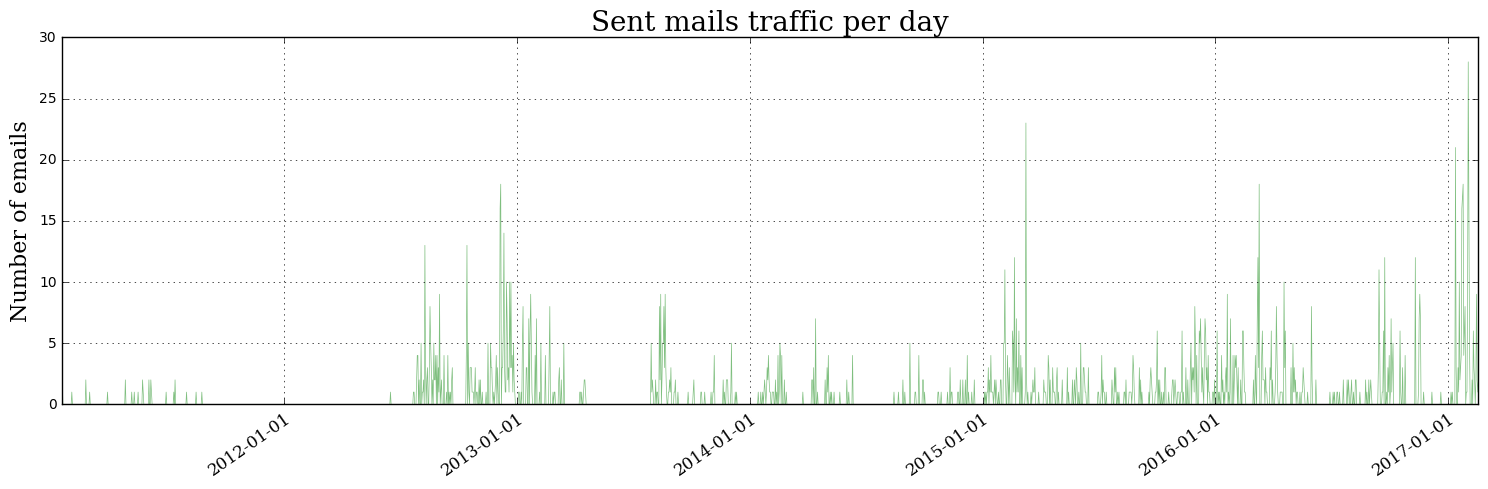

In [9]:
# plot the counts per day
fig = plt.figure(figsize=[15, 5])
ax = date_counts.plot(kind='line', linewidth=0.5, alpha=0.5, color='g')

ax.grid(True)
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Sent mails traffic per day', fontproperties=title_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-day-destacados.png', dpi=96)
plt.show()

## Plot the traffic month by month

In [10]:
# get the count per month
all_months = [x[:-3] for x in all_dates]
month_counts = pd.Series(all_months).value_counts().sort_index()

In [11]:
# not every month necessarily has a message, so fill in missing months in the range with zeros
date_range = pd.date_range(start=min(all_dates), end=max(all_dates), freq='D')
months_range = date_range.map(lambda x: str(x.date())[:-3])
index = np.unique(months_range)
month_counts = month_counts.reindex(index, fill_value=0)

In [12]:
# create a series of labels for the plot: each january
xlabels = pd.Series([label if '-01' in label else None for label in month_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]
xlabels.head()

0     2011-01
12    2012-01
24    2013-01
36    2014-01
48    2015-01
dtype: object

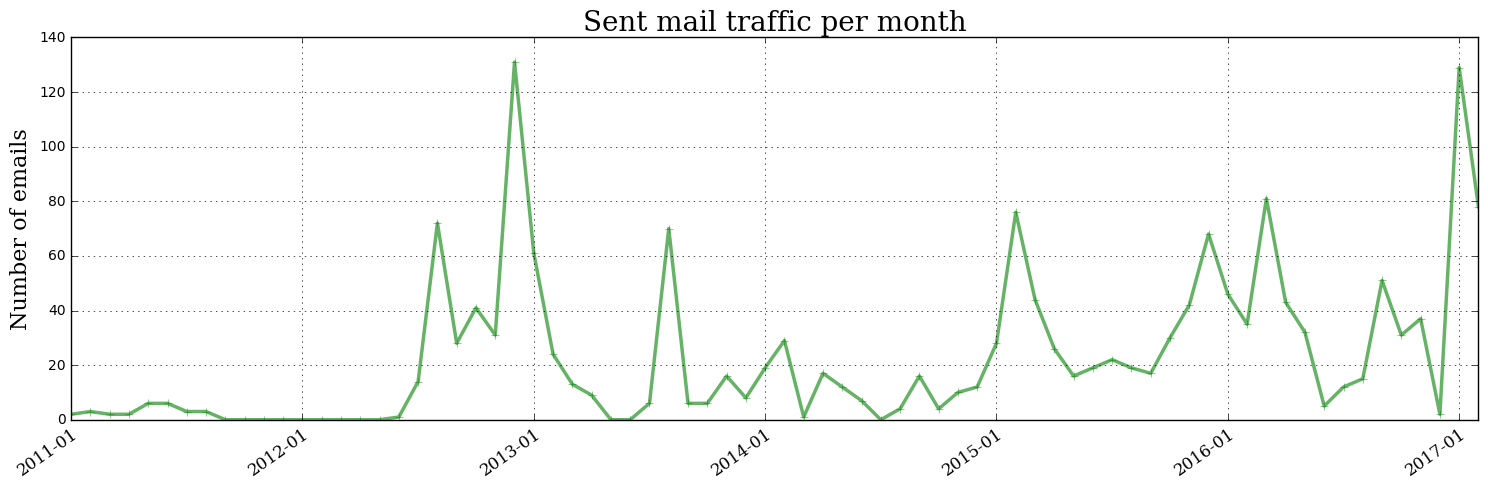

In [13]:
# plot the counts per month
fig = plt.figure(figsize=[15, 5])
ax = month_counts.plot(kind='line', linewidth=2.5, alpha=0.6, color='g', marker='+', markeredgecolor='g')

ax.grid(True)
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Sent mail traffic per month', fontproperties=title_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-month.png', dpi=96)
plt.show()

## Plot the mail traffic by the day of the week

In [14]:
# get the count per day of the week
day_counts = pd.DataFrame()
day_counts['count'] = date_counts
day_counts['day_of_week'] = date_counts.index.map(lambda x: parse_datetime(x).weekday())
mean_day_counts = day_counts.groupby('day_of_week')['count'].mean()
xlabels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

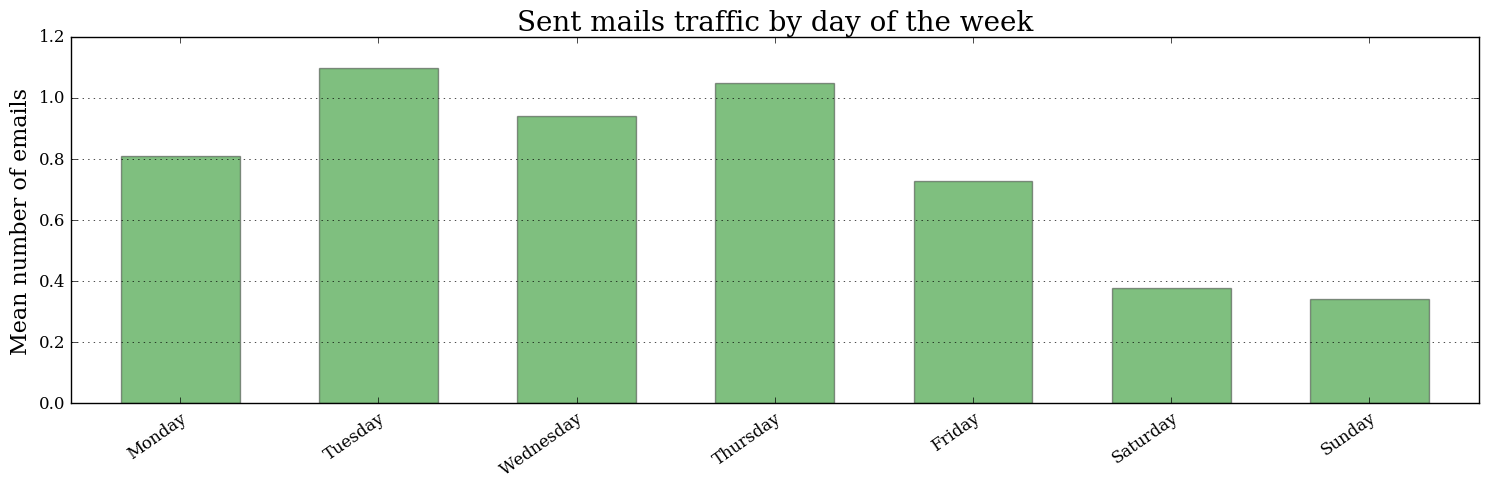

In [15]:
fig = plt.figure(figsize=[15, 5])
ax = mean_day_counts.plot(kind='bar', width=0.6, alpha=0.5, color='g', edgecolor='#333333')

ax.yaxis.grid(True)
ax.set_xticklabels(xlabels, rotation=35, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Sent mails traffic by day of the week', fontproperties=title_font)
ax.set_xlabel('')
ax.set_ylabel('Mean number of emails', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-day-week.png', dpi=96)
plt.show()

## Plot the mail traffic by the hour of the day

In [16]:
# get the count per hour of the day
times = pd.Series(all_times).map(lambda x: '{:02}:00'.format(parse_datetime(x).hour))
time_counts = times.value_counts().sort_index()
time_counts.head()

00:00    85
01:00    53
02:00    16
03:00    17
04:00     2
dtype: int64

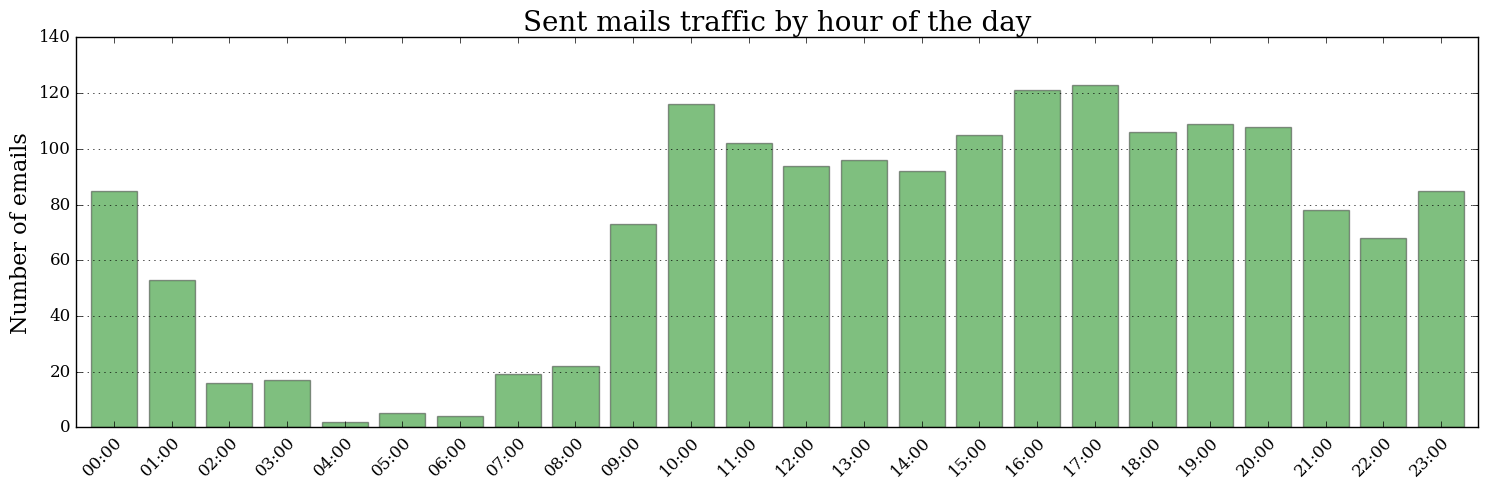

In [17]:
fig = plt.figure(figsize=[15, 5])
ax = time_counts.plot(kind='bar', width=0.8, alpha=0.5, color='g', edgecolor='#333333')

ax.yaxis.grid(True)
ax.set_xticklabels(time_counts.index, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
for label in ax.get_yticklabels():
    label.set_fontproperties(ticks_font)

ax.set_title('Sent mails traffic by hour of the day', fontproperties=title_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-hour.png', dpi=96)
plt.show()

## Plot the mail traffic by the minute of the day

In [18]:
# get the count per minute of the day, as hh:mm
minutes = pd.Series(all_times).map(lambda x: '{:02}:{:02}'.format(parse_datetime(x).hour, parse_datetime(x).minute))
minute_counts = minutes.value_counts().sort_index()

In [19]:
# not every minute necessarily has a message, so fill in missing times with zeros
time_range = pd.date_range(start='0:00', end='23:59', freq='1min')
index = time_range.map(lambda x: '{:02}:{:02}'.format(x.hour, x.minute))
minute_counts = minute_counts.reindex(index, fill_value=0)

In [20]:
# create a series of labels for the plot: each new hour
xlabels = pd.Series([label if ':00' in label else None for label in minute_counts.index])
xlabels = xlabels[pd.notnull(xlabels)]

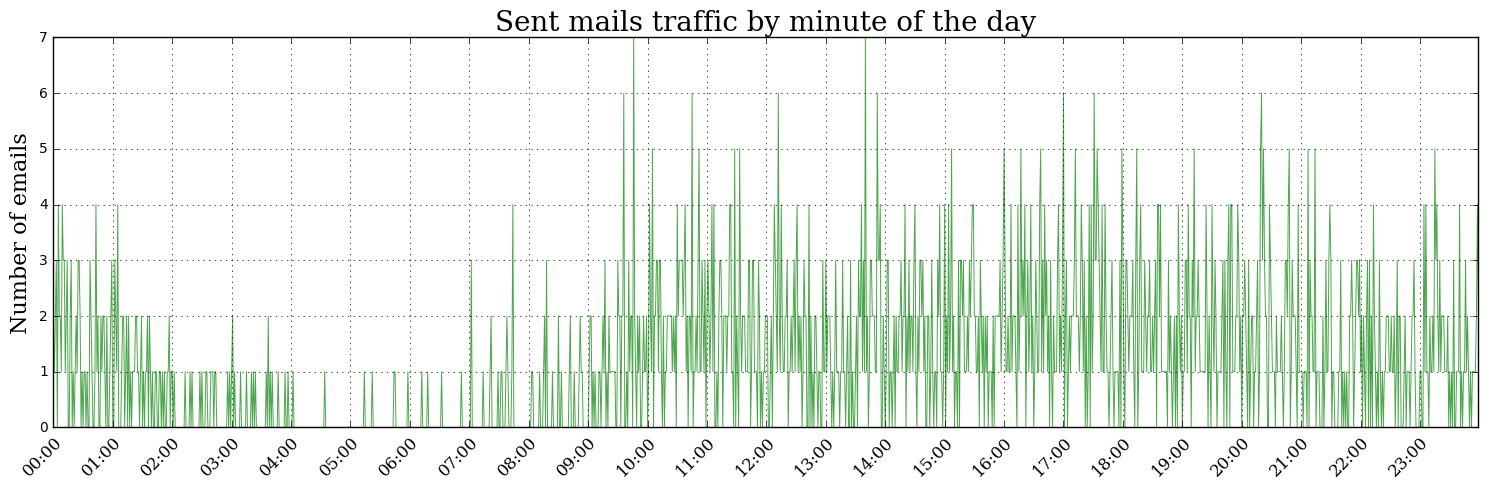

In [21]:
# plot the counts per minute
fig = plt.figure(figsize=[15, 5])
ax = minute_counts.plot(kind='line', linewidth=0.7, alpha=0.7, color='g')

ax.grid(True)
ax.set_xticks(xlabels.index)
ax.set_xticklabels(xlabels, rotation=45, rotation_mode='anchor', ha='right', fontproperties=ticks_font)
ax.set_ylabel('Number of emails', fontproperties=label_font)
ax.set_title('Sent mails traffic by minute of the day', fontproperties=title_font)

fig.tight_layout()
fig.savefig('images/gmail-traffic-minute.png', dpi=96)
plt.show()

As we can see here if we want to develop a recomender system around this user better we send ads based on how likely the user is online, we can now that when he/she is writing emails down

For this user the most likely time is around 10 to eleven and 16 to 17, Tuesdays and Thursdays, and also is important to say that there's such an active account between November and February